In [2]:
from influxdb_client import InfluxDBClient

client = InfluxDBClient(url="http://157.230.220.56:8086/", token="CVUoz3cmuK-s4CwjJskqjiQCd9hvaPIfNfb1MPzvcSxFnbvVBL7Pa83-WzXsZ-17WZwoxLkCzXUZ_vX2Soqfsg==", org="core/app")



In [253]:
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS

client = InfluxDBClient(url="http://157.230.220.56:8086/", token="OLSlIRVAU3eFqLz3bdsmQ5o33X2VrpMGmhbFJ4A0qLxXi6CWLaPl92RGuT5V7blVQ5vFliBF_4Xxlkvmwv3v9A==", org="celestia")


query_api = client.query_api()

query = '''
data = from(bucket: "e2e")
  |> range(start: 0)
  |> filter(fn: (r) => r["_measurement"] == "consensus" and 
    r.chain_id == "ci-zy4vJM"
    )
  |> drop(columns: ["_start", "_stop"])
  |> filter(fn: (r) => r._field == "round_data" )
  |> map(fn: (r) => ({time: r._time, node_id: r.node_id, data: r._value}))
  |> yield(name: "data")
'''

result = query_api.query(query=query)






In [254]:

import pandas as pd
import re

pattern = r'\[(\d+)\s+(\d+)\s+([^\]]+)\]'

def match_string(data_str):
    match = re.match(pattern, data_str)
    height = int(match.group(1))
    round_ = int(match.group(2))
    step = match.group(3)
    return height, round_, step

def parse_influxdb_results(results):
    # Create an empty list to hold the rows of data
    rows = []
    
    # Loop over each table in the results
    for table in results:
        # Loop over each row in the table
        for row in table.records:
            # Parse the data column into a list
            data_str = row["data"]
            
            # Extract the values from the list and the other columns
            height, round_, step = match_string(data_str)
            node_id = row["node_id"]
            time = pd.Timestamp(row["time"])
            
            # Append the values to the list of rows
            rows.append([height, node_id, round_, step, time])
    
    # Create a Pandas DataFrame from the rows and set the column names
    df = pd.DataFrame(rows, columns=['height', 'node_id', 'round', 'step', 'time'])
    
    return df

pdf = parse_influxdb_results(result)

In [255]:
pdf.sort_values("height")

,height,node_id,round,step,time
0,1000,0b529c309608172a29c49979394734260b42acfb,0,RoundStepPropose,2023-03-10 21:46:39.322123+00:00
432,1000,2551a13ed720101b271a5df4816d1e4b3d3bd133,1,RoundStepPropose,2023-03-10 21:47:00.793574+00:00
433,1000,2551a13ed720101b271a5df4816d1e4b3d3bd133,1,RoundStepPrecommit,2023-03-10 21:47:00.793601+00:00
434,1000,2551a13ed720101b271a5df4816d1e4b3d3bd133,1,RoundStepCommit,2023-03-10 21:47:00.793711+00:00
851,1000,30108a336fe6a22a1c78557d600e88c11571499b,0,RoundStepPropose,2023-03-10 21:46:40.386280+00:00
...,...,...,...,...,...
2411,1082,539ffc12a0ac78970dab31ae8cdcfdd4285b2162,0,RoundStepNewHeight,2023-03-10 21:49:09.092037+00:00
1276,1082,30108a336fe6a22a1c78557d600e88c11571499b,0,RoundStepNewHeight,2023-03-10 21:49:09.096691+00:00
850,1082,2551a13ed720101b271a5df4816d1e4b3d3bd133,0,RoundStepNewHeight,2023-03-10 21:49:09.167820+00:00
429,1082,0b529c309608172a29c49979394734260b42acfb,0,RoundStepNewHeight,2023-03-10 21:49:09.134812+00:00


In [240]:
# def find_duplicate_rounds(df):
#     # Group the data by height and count the number of unique rounds for each height
#     grouped = df.groupby('height')['round'].nunique()
    
#     # Filter the data to only keep rows where the number of unique rounds is greater than one
#     duplicates = grouped[grouped > 1].index.tolist()
#     filtered = df[df['height'].isin(duplicates)]
    
#     # Create a new DataFrame from the filtered data
#     new_df = pd.DataFrame(filtered)
    
#     return new_df

# dd = find_duplicate_rounds(pdf)

In [239]:
# import matplotlib.pyplot as plt

# # Get the unique node IDs
# nodes = pdf["node_id"].unique()

# # Create a scatter plot for each node
# for node in nodes:
#     node_df = pdf[pdf["node_id"] == node]
#     plt.scatter(node_df["time"], node_df["height"], label=node)

# # Add labels and legend
# plt.xlabel("Time")
# plt.ylabel("Height")
# plt.legend()

# # Show the plot
# plt.show()

In [80]:
# # Group the dataframe by height and node_id, and count the number of entries per group
# grouped_df = pdf.groupby(['height', 'node_id']).size()

# # Select only the groups where the count is greater than 1
# multiple_rounds = grouped_df[grouped_df > 1]

# # heights with multiple rounds
# multi_round_heights = multiple_rounds.index.get_level_values('height').unique()

In [256]:
# Define a dictionary to map each step to a color
step_colors = {'RoundStepNewHeight': 'blue', 
               'RoundStepPropose': 'orange', 
               'RoundStepPrevote': 'green', 
               'RoundStepPrecommit': 'red', 
               'RoundStepCommit': 'purple'}

from matplotlib.backends.backend_pdf import PdfPages
pdf_pages = PdfPages('my_plots_2.pdf')

fig_width = 16
fig_height = 4
fig_padding = 1.9

left_margin = 1
right_margin = 1
bottom_margin = 1
top_margin = 1

def plot_multiple_rounds(df):
    df['time'] = df['time'] - df['time'].min()
    
    # Group the data by height and count the number of unique rounds for each height
    grouped = df.groupby('height')['round'].nunique()
    
    # Filter the data to only keep rows where the number of unique rounds is greater than one
    duplicates = grouped[grouped > 1].index.tolist()
    filtered = df[df['height'].isin(duplicates)]
    
    # Iterate over each height that has multiple rounds
    for height in duplicates:
        # Get the data for the current height
        height_data = filtered[filtered['height'] == height]
        
        # Get a list of all unique node_ids for the current height
        nodes = height_data['node_id'].unique().tolist()
        
        # Create a dictionary to hold the data for each node
        node_data = {node: height_data[height_data['node_id'] == node] for node in nodes}
        
        # Create a new figure
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        
        # Set the y-ticks to the node IDs
        ax.set_yticks(range(len(nodes)))
        ax.set_yticklabels(nodes)
        
        # Map each step to a color
        step_data = height_data.copy()
        step_data['step_color'] = step_data['step'].map(step_colors).fillna('grey')
        
        # Plot each step for each node
        for node, data in node_data.items():
            for step in data['step'].unique():
                step_data = data[data['step'] == step]
                ax.scatter(step_data['time'], [nodes.index(node)] * len(step_data), s=50, c=step_data["step_color"], marker='|')
        
        # Add a legend and axis labels
        ax.legend(height_data['step'].unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xlabel('Relative Time (ns)')
        ax.set_ylabel('Node ID')
        
        # Set the title of the plot to the current height
        ax.set_title(f'Height {height}')
        
        #fig.tight_layout(pad=fig_padding)
        # Calculate the maximum possible values for the margins
        left_margin = 0.5 * fig_padding / fig_width
        right_margin = 0.5 * fig_padding / fig_width
        bottom_margin = 0.5 * fig_padding / fig_height
        top_margin = 0.5 * fig_padding / fig_height

        # Set the margins of the plot
        fig.subplots_adjust(left=.3, right=.7,
                            bottom=bottom_margin, top=1-top_margin)

        # Show the plot
        plt.plot()
        pdf_pages.savefig()

def map_step_color(step):
#     # Define a dictionary to map each step to a color
#     step_colors = {'RoundStepNewHeight': 'blue', 
#                    'RoundStepPropose': 'orange', 
#                    'RoundStepPrevote': 'green', 
#                    'RoundStepPrecommit': 'red', 
#                    'RoundStepCommit': 'purple'}
    
    # Return the color for the given step
    return step_colors.get(step, 'black')

pdf['step_color'] = pdf['step'].apply(map_step_color)

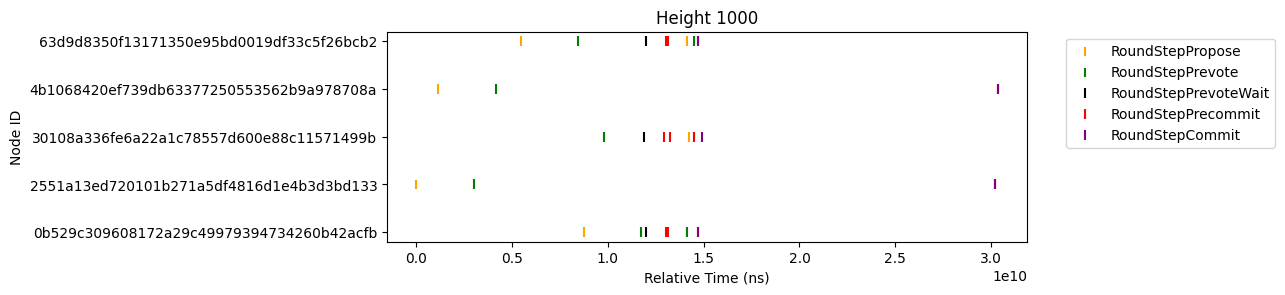

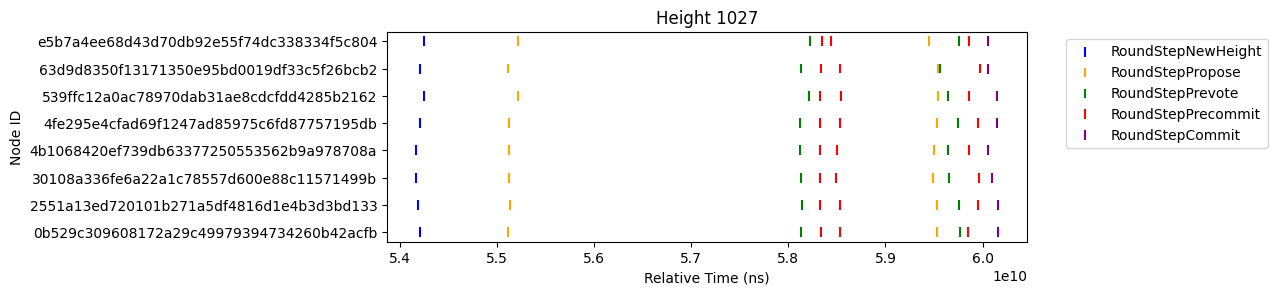

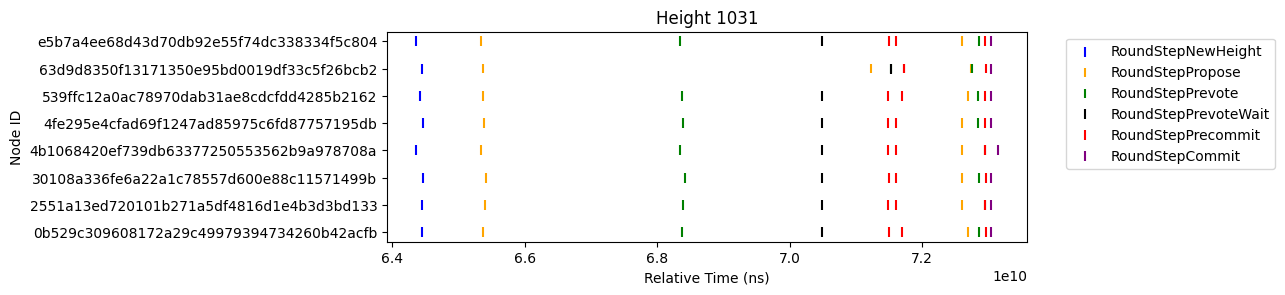

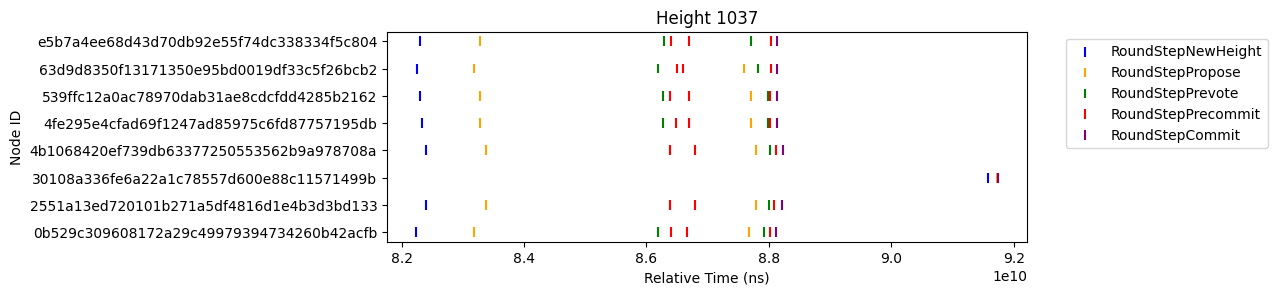

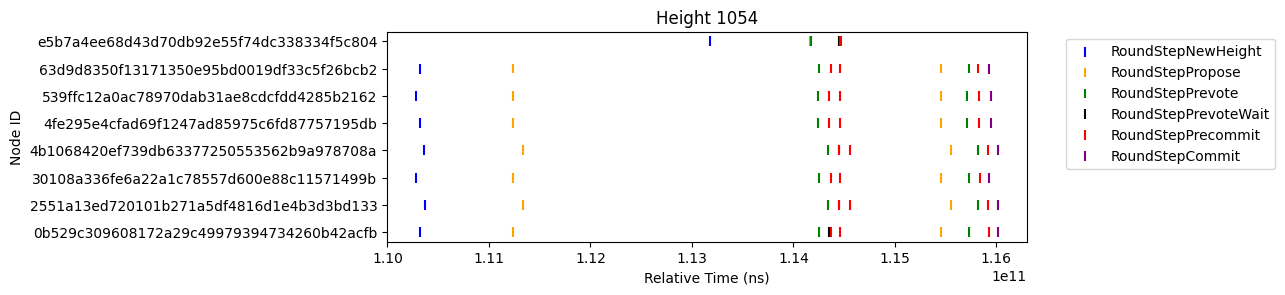

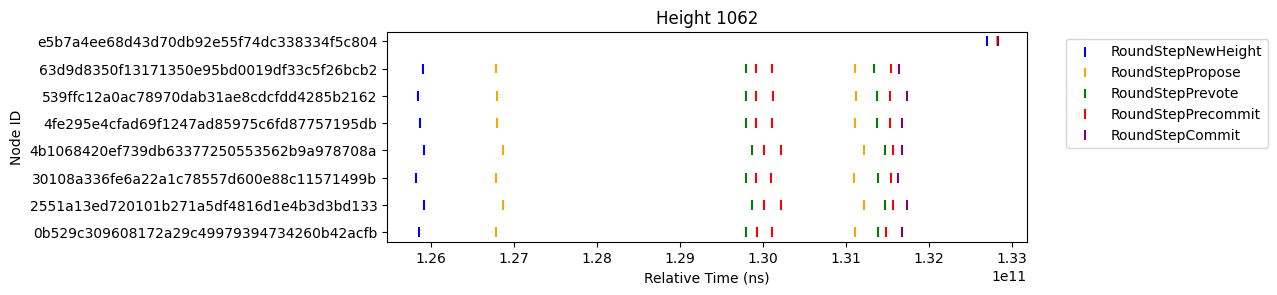

In [257]:
plot_multiple_rounds(pdf)
pdf_pages.close()